# About The Dataset

- The Coral Spawning Database includes over 6,000 observations of the time or day of spawning for over 300 scleractinian species from 101 sites in the Indo-Pacific.

### Dataset: 
- [The coral spawning database](https://data.ncl.ac.uk/articles/dataset/Coral_Spawning_Database/13082333/1?file=25048202)


### Reference
- Baird, A.H., Guest, J.R., Edwards, A.J. et al. [An Indo-Pacific coral spawning database](https://www.nature.com/articles/s41597-020-00793-8#Abs1). Sci Data 8, 35 (2021). https://doi.org/10.1038/s41597-020-00793-8

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.regression import *
from lightgbm import LGBMRegressor, LGBMClassifier, Booster

import warnings
warnings.filterwarnings('ignore')

# 01_Get the Data

## Load data 

In [2]:
df = pd.read_csv('/Users/kt/Desktop/Project/coral-spawning/02_EDA/coral_spawning_cleaned.csv')
#df.info()
df.head()

,Ecoregion,Country,Site,Latitude,Longitude,Genus,Species,Taxon,N_min,Date,Start_decimal,STrSS,Gamete_release,DoSRtNFM,ToSS_decimal,ToSR_decimal,daylen_decimal,sunset,sunrise
0,"Tuvalu, Samoa and Tonga",American Samoa,Faga’alu,-14.279444,-170.700833,Porites,cylindrica,Porites cylindrica,1.0,1988-10-27,20.500000,2.116667,Sperm,3,18.383333,5.816667,13.34,18.23,5.49
1,"Tuvalu, Samoa and Tonga",American Samoa,Faga’alu,-14.279444,-170.700833,Porites,cylindrica,Porites cylindrica,15.0,1995-11-09,20.583333,2.116667,Sperm,3,18.466667,5.750000,13.42,18.27,5.45
2,"Tuvalu, Samoa and Tonga",American Samoa,Faga’alu,-14.279444,-170.700833,Acropora,muricata,Acropora muricata,1.0,1995-11-10,20.333333,1.866667,Bundles,4,18.466667,5.750000,13.43,18.28,5.45
3,"Tuvalu, Samoa and Tonga",American Samoa,Faga’alu,-14.279444,-170.700833,Merulina,ampliata,Merulina ampliata,6.0,1995-11-11,19.750000,1.283333,Bundles,5,18.466667,5.733333,13.44,18.28,5.44
4,"Tuvalu, Samoa and Tonga",American Samoa,Faga’alu,-14.279444,-170.700833,Montipora,grisea,Montipora grisea,3.0,1995-11-11,20.750000,2.283333,Bundles,5,18.466667,5.733333,13.44,18.28,5.44


# Time Series - Forcasting number of spawning colony 

In [3]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
  
    
    X = df[['dayofweek','quarter','month','year',
            'dayofyear','dayofmonth','weekofyear',
            'N_min', 'DoSRtNFM', 'daylen_decimal', 'sunset', 'sunrise', 'Start_decimal']]
    X.index=df.index
    return X

In [4]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

In [5]:
# Select columns for time-series forcasting
df = df[['Date', 'N_min', 'DoSRtNFM', 'daylen_decimal', 'sunset', 'sunrise', 'Start_decimal']]
df.head()

,Date,N_min,DoSRtNFM,daylen_decimal,sunset,sunrise,Start_decimal
0,1988-10-27,1.0,3,13.34,18.23,5.49,20.500000
1,1995-11-09,15.0,3,13.42,18.27,5.45,20.583333
2,1995-11-10,1.0,4,13.43,18.28,5.45,20.333333
3,1995-11-11,6.0,5,13.44,18.28,5.44,19.750000
4,1995-11-11,3.0,5,13.44,18.28,5.44,20.750000


In [6]:
aggregated = df.groupby('Date', as_index=True).mean()
aggregated

,N_min,DoSRtNFM,daylen_decimal,sunset,sunrise,Start_decimal
Date,,,,,,
1978-11-18,1.000000,3.0,14.17,18.15,4.58,16.000000
1978-11-19,1.000000,4.0,14.18,18.16,4.58,16.000000
1978-11-20,1.000000,5.0,14.19,18.17,4.58,16.000000
1978-11-21,1.000000,6.0,14.19,18.17,4.58,16.000000
1978-11-22,1.000000,7.0,14.20,18.18,4.58,16.000000
...,...,...,...,...,...,...
2019-11-12,6.333333,0.0,13.11,18.11,5.00,20.750000
2019-11-16,1.000000,3.0,13.58,19.22,6.24,21.520833
2019-11-18,1.000000,5.0,13.00,19.24,6.24,21.554762


In [7]:
# set date as index
aggregated.index = pd.to_datetime(aggregated.index)
aggregated

,N_min,DoSRtNFM,daylen_decimal,sunset,sunrise,Start_decimal
Date,,,,,,
1978-11-18,1.000000,3.0,14.17,18.15,4.58,16.000000
1978-11-19,1.000000,4.0,14.18,18.16,4.58,16.000000
1978-11-20,1.000000,5.0,14.19,18.17,4.58,16.000000
1978-11-21,1.000000,6.0,14.19,18.17,4.58,16.000000
1978-11-22,1.000000,7.0,14.20,18.18,4.58,16.000000
...,...,...,...,...,...,...
2019-11-12,6.333333,0.0,13.11,18.11,5.00,20.750000
2019-11-16,1.000000,3.0,13.58,19.22,6.24,21.520833
2019-11-18,1.000000,5.0,13.00,19.24,6.24,21.554762


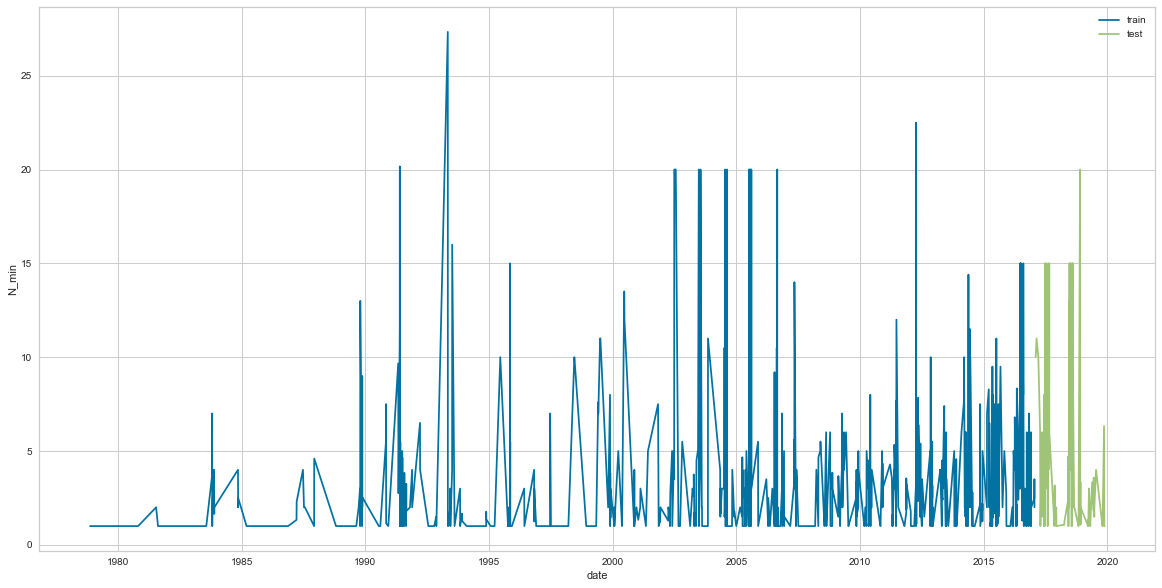

In [8]:
aggregated=create_features(aggregated)
train, test = split_data(aggregated, '2017-01-19') 

plt.figure(figsize=(20,10))
plt.xlabel('date')
plt.ylabel('N_min')
plt.plot(train.index,train['N_min'],label='train')
plt.plot(test.index,test['N_min'],label='test')
plt.legend()
plt.show()

In [17]:
reg = setup(data = train, 
            target = 'N_min',
            numeric_imputation = 'mean',
            categorical_features = ['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear'], 
            transformation = True, transform_target = True, 
            remove_multicollinearity = True, multicollinearity_threshold = 0.95, )

,Description,Value
0,Session id,1750
1,Target,N_min
2,Target type,Regression
3,Original data shape,"(933, 13)"
4,Transformed data shape,"(933, 32)"
5,Transformed train set shape,"(653, 32)"
6,Transformed test set shape,"(280, 32)"
7,Numeric features,5
8,Categorical features,7
9,Preprocess,1


In [18]:
# returns best models (out of 10)
top3 = compare_models(n_select = 3)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.7507,11.2950,3.3204,0.1334,0.5059,0.5239,0.9080
ridge,Ridge Regression,1.9956,14.0802,3.7193,-0.0825,0.5859,0.5806,0.7780
knn,K Neighbors Regressor,2.1624,14.1838,3.7290,-0.0877,0.6209,0.7414,0.8250
en,Elastic Net,2.0364,14.3610,3.7575,-0.1057,0.5967,0.5959,0.9980
lasso,Lasso Regression,2.0374,14.3982,3.7625,-0.1087,0.5978,0.5952,1.1110
llar,Lasso Least Angle Regression,2.0374,14.3982,3.7625,-0.1087,0.5978,0.5952,1.9730
omp,Orthogonal Matching Pursuit,2.0459,14.5154,3.7787,-0.1187,0.6023,0.5957,1.3610
lr,Linear Regression,2.0432,14.5194,3.7791,-0.1189,0.6020,0.5950,1.0630
lar,Least Angle Regression,1.8455,12.8084,3.3608,-0.1251,0.5425,0.5930,1.3830
dummy,Dummy Regressor,2.1004,14.7251,3.8074,-0.1367,0.6148,0.6259,0.7220


Processing:   0%|          | 0/83 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.7328,8.3243,2.8852,0.1278,0.4701,0.5353
1,1.8469,11.5524,3.3989,0.0242,0.5410,0.4968
2,1.4917,9.4644,3.0764,0.2314,0.4885,0.4509
3,1.7569,9.4819,3.0793,0.0749,0.5240,0.5784
4,1.7078,15.0528,3.8798,0.1621,0.4894,0.4883
5,2.2120,13.2287,3.6371,-0.0327,0.6054,0.6464
6,1.5612,7.7133,2.7773,0.2527,0.4616,0.5364
7,2.0689,19.5871,4.4257,0.0951,0.5471,0.4526
8,1.2824,7.0160,2.6488,0.4096,0.4121,0.4257


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

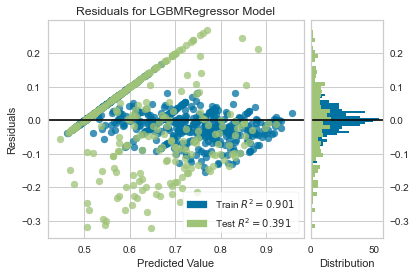

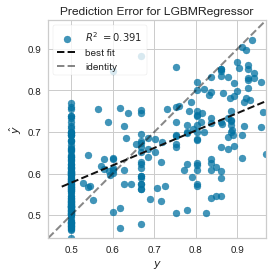

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.7396,9.8244,3.1344,-0.0294,0.5187,0.5064
1,2.0469,12.8662,3.5869,-0.0867,0.5990,0.6047
2,1.7883,11.6993,3.4204,0.0499,0.5360,0.5059
3,1.7118,8.9704,2.9951,0.1248,0.5286,0.6080
4,1.8484,16.8170,4.1009,0.0639,0.5260,0.5197
5,2.1799,13.1629,3.6281,-0.0275,0.5921,0.5889
6,1.7839,9.9422,3.1531,0.0367,0.5453,0.6281
7,2.2485,22.7757,4.7724,-0.0522,0.6180,0.4969
8,1.7180,10.6224,3.2592,0.1061,0.4949,0.5153


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


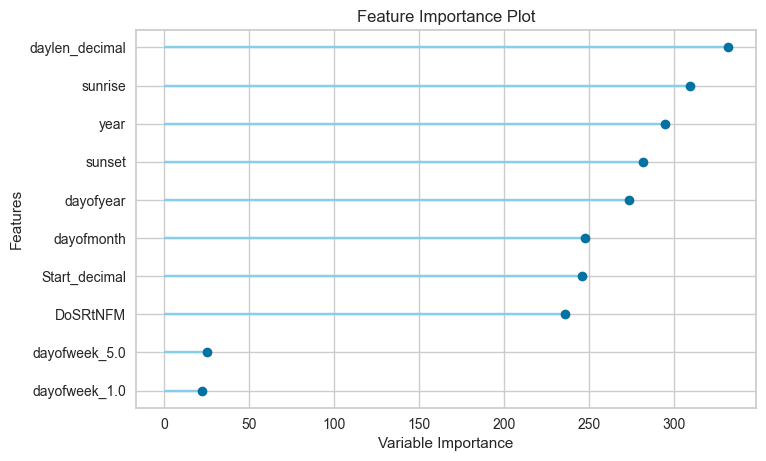

In [19]:
# we create a model using light gbm
lightgbm = create_model('lightgbm')

plot_model(lightgbm)

plot_model(lightgbm, plot = 'error')

# tune model
tuned_lightgbm = tune_model(lightgbm) 
plot_model(tuned_lightgbm, plot='feature')


In [20]:
predict_model(tuned_lightgbm);


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.7126,11.5641,3.4006,0.1850,0.5032,0.4666


In [21]:
final_lightgbm = finalize_model(tuned_lightgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=40,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.2,
              n_estimators=150, n_jobs=-1, num_leaves=100, objective=None,
              random_state=7424, reg_alpha=0.2, reg_lambda=0.2, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


LGBMRegressor(learning_rate=0.3, max_depth=40, min_split_gain=0.2,
              n_estimators=150, n_jobs=-1, num_leaves=100, random_state=7424,
              reg_alpha=0.2, reg_lambda=0.2, silent=True)

In [22]:
def plot_series(time, series,i, format="-", start=0, end=None):
    #plt.figure(figsize=(20,10))
    plt.plot(time[start:end], series[start:end], format,label=i)
    plt.xlabel("Date")
    plt.ylabel("Starting Time")
    plt.legend()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.1078,14.2529,3.7753,-0.0045,0.5890,0.7006


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.4571,24.2477,4.9242,-0.1606,0.7124,0.6881


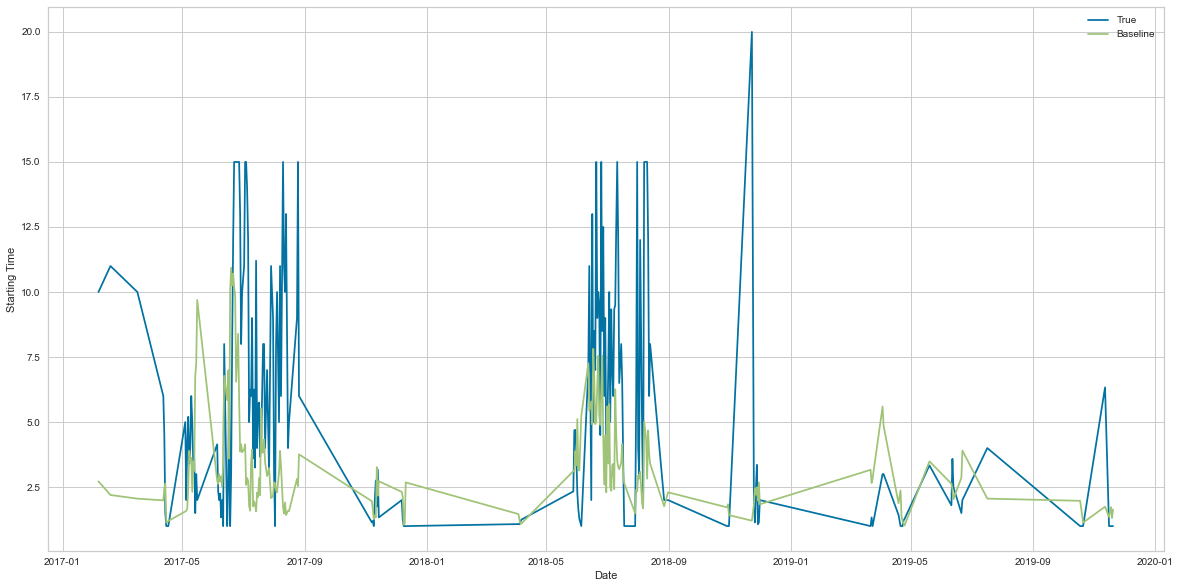

In [23]:
predict_model(final_lightgbm);

# get prediction values to plot
unseen_predictions = predict_model(final_lightgbm, data=test)
unseen_predictions.head()
#unseen_predictions.loc[unseen_predictions['Label'] < 0, 'Label'] = 0 #removing any negative values

plt.figure(figsize=(20,10))
plot_series(test.index, test['N_min'],"True")
#plot_series(train['ds'],train['y'])
plot_series(test.index, unseen_predictions['prediction_label'],"Baseline")


## Resources:

### Pycaret
-[Pycaret Docs](https://pycaret.gitbook.io/docs/)

-[5 things you are doing wrong in PyCaret](https://towardsdatascience.com/5-things-you-are-doing-wrong-in-pycaret-e01981575d2a)


Note: 
- I need to study more about time-series